# Double Unet Architecture
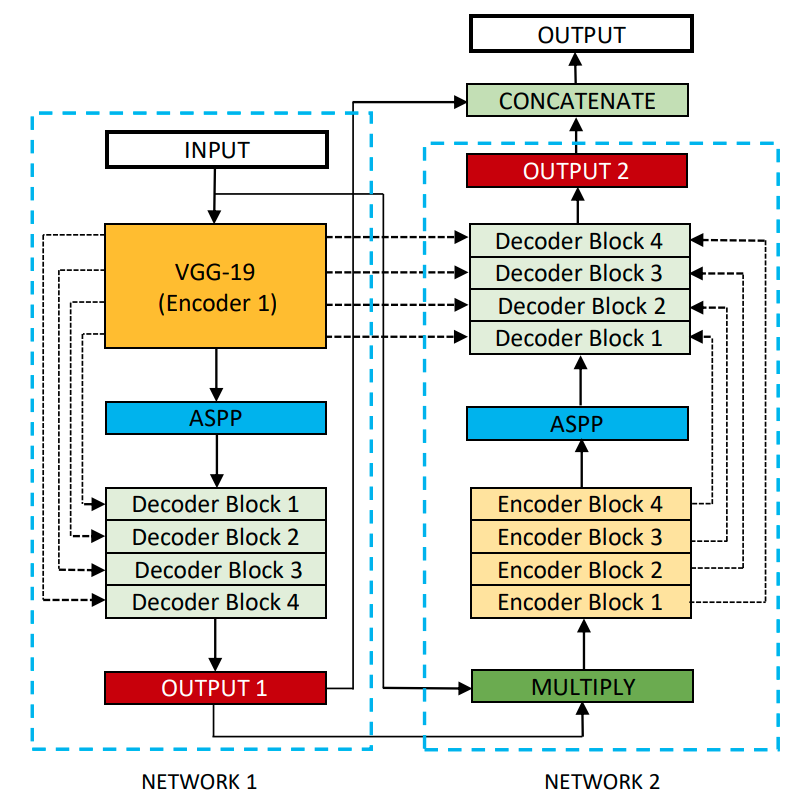

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x


def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs)
    return model

# Prepare Data

In [2]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import cv2
import warnings
warnings.filterwarnings("ignore")
import os

## 1. Helper Function

In [3]:
def read_image(x):
    x = x.decode()
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    return image

def read_mask(y):
    y = y.decode()
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask/255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

def parse_data(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        y = np.concatenate([y, y], axis=-1)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([512, 512, 3])
    y.set_shape([512, 512, 2])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=32)
    dataset = dataset.map(map_func=parse_data)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    return dataset


In [4]:
from sklearn.utils import shuffle
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model
def create_dir(path):
    """ Create a directory. """
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

def read_data(x, y):
    """ Read the image and mask from the given path. """
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    return image, mask

def read_params():
    """ Reading the parameters from the JSON file."""
    with open("params.json", "r") as f:
        data = f.read()
        params = json.loads(data)
        return params

def load_data(path):
    """ Loading the data from the given path. """
    images_path = os.path.join(path, "image/*")
    masks_path  = os.path.join(path, "mask/*")

    images = glob(images_path)
    masks  = glob(masks_path)

    return images, masks

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_model_weight(path):
    with CustomObjectScope({
        'dice_loss': dice_loss,
        'dice_coef': dice_coef,
        'bce_dice_loss': bce_dice_loss,
        'focal_loss': focal_loss,
        'iou': iou
        }):
        model = load_model(path)
    return model

## 2. Import Data

In [5]:
train_path = "D:/Pressure Ulcer/Thesis Data/train_data/aug_data/"
test_path = "D:/Pressure Ulcer/Thesis Data/test data/"

train_images = glob(train_path + "images/*.png")
train_masks = glob(train_path + "masks/*.png")
test_images = glob(test_path + "images/*.png")
test_masks = glob(test_path + "masks/*.png")
len(train_images), len(test_images)

(1752, 73)

In [6]:
# Shuffling
train_x, train_y = shuffling(train_images, train_masks)

## 3. Evaluation Metrics

In [7]:
# Evaluation Metrics
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import os
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

In [9]:
from tensorflow.keras.metrics import *
model = build_model(shape=(512, 512,3))
metrics = [
    dice_coef,
    iou,
    #Recall(),
    #Precision(),
    #Accuracy()
]

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [12]:
from tensorflow.keras.optimizers import Adam, Nadam
model_path = "DoubleUNet_VGG19_noptw_bestmodel.hdf5"
batch_size = 8
epochs = 500
lr = 1e-4
shape = (512, 512, 3)
model.compile(loss=bce_dice_loss, optimizer=Adam(lr), metrics=metrics)

In [13]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
#valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [14]:
from tensorflow.keras.callbacks import *
callbacks = [
    ModelCheckpoint(model_path),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=20),
    #CSVLogger("data.csv"),
    #TensorBoard(),
    EarlyStopping(monitor='loss', patience=50, restore_best_weights=False)
]

train_steps = (len(train_x)//batch_size)
#valid_steps = (len(valid_x)//batch_size)

if len(train_x) % batch_size != 0:
    train_steps += 1

#if len(valid_x) % batch_size != 0:
#    valid_steps += 1


In [15]:
%%time
model.fit( train_dataset,
            epochs=epochs,
            #validation_data=valid_dataset,
            steps_per_epoch=train_steps,
            #validation_steps=valid_steps,
            callbacks=callbacks,
            shuffle=False)

Epoch 1/500
219/219 [==============================] - 200s 839ms/step - loss: 0.6895 - dice_coef: 0.6816 - iou: 0.5225
Epoch 2/500
219/219 [==============================] - 174s 797ms/step - loss: 0.4811 - dice_coef: 0.7686 - iou: 0.6261
Epoch 3/500
219/219 [==============================] - 175s 797ms/step - loss: 0.3821 - dice_coef: 0.8112 - iou: 0.6842
Epoch 4/500
219/219 [==============================] - 175s 798ms/step - loss: 0.3032 - dice_coef: 0.8489 - iou: 0.7388
Epoch 5/500
219/219 [==============================] - 175s 798ms/step - loss: 0.2594 - dice_coef: 0.8715 - iou: 0.7735
Epoch 6/500
219/219 [==============================] - 175s 798ms/step - loss: 0.2125 - dice_coef: 0.8944 - iou: 0.8100
Epoch 7/500
219/219 [==============================] - 175s 797ms/step - loss: 0.1855 - dice_coef: 0.9095 - iou: 0.8349
Epoch 8/500
219/219 [==============================] - 175s 798ms/step - loss: 0.1598 - dice_coef: 0.9231 - iou: 0.8576
Epoch 9/500
219/219 [===================

219/219 [==============================] - 174s 797ms/step - loss: 0.0109 - dice_coef: 0.9955 - iou: 0.9910
Epoch 69/500
219/219 [==============================] - 174s 796ms/step - loss: 0.0110 - dice_coef: 0.9954 - iou: 0.9908
Epoch 70/500
219/219 [==============================] - 175s 797ms/step - loss: 0.0112 - dice_coef: 0.9953 - iou: 0.9907
Epoch 71/500
219/219 [==============================] - 174s 796ms/step - loss: 0.0113 - dice_coef: 0.9953 - iou: 0.9906
Epoch 72/500
219/219 [==============================] - 174s 796ms/step - loss: 0.0108 - dice_coef: 0.9955 - iou: 0.9911
Epoch 73/500
219/219 [==============================] - 174s 796ms/step - loss: 0.0105 - dice_coef: 0.9956 - iou: 0.9912
Epoch 74/500
219/219 [==============================] - 174s 796ms/step - loss: 0.0106 - dice_coef: 0.9956 - iou: 0.9912
Epoch 75/500
219/219 [==============================] - 174s 796ms/step - loss: 0.0106 - dice_coef: 0.9956 - iou: 0.9912
Epoch 76/500
219/219 [=======================

219/219 [==============================] - 175s 797ms/step - loss: 0.0055 - dice_coef: 0.9977 - iou: 0.9955
Epoch 136/500
219/219 [==============================] - 175s 798ms/step - loss: 0.0052 - dice_coef: 0.9978 - iou: 0.9956
Epoch 137/500
219/219 [==============================] - 175s 797ms/step - loss: 0.0052 - dice_coef: 0.9978 - iou: 0.9956
Epoch 138/500
219/219 [==============================] - 175s 797ms/step - loss: 0.0054 - dice_coef: 0.9978 - iou: 0.9955
Epoch 139/500
219/219 [==============================] - 175s 797ms/step - loss: 0.0055 - dice_coef: 0.9977 - iou: 0.9955
Epoch 140/500
219/219 [==============================] - 175s 798ms/step - loss: 0.0055 - dice_coef: 0.9977 - iou: 0.9954
Epoch 141/500
219/219 [==============================] - 175s 797ms/step - loss: 0.0057 - dice_coef: 0.9976 - iou: 0.9952
Epoch 142/500
219/219 [==============================] - 175s 798ms/step - loss: 0.0058 - dice_coef: 0.9976 - iou: 0.9952
Epoch 143/500
219/219 [===============

219/219 [==============================] - 175s 797ms/step - loss: 0.0018 - dice_coef: 0.9993 - iou: 0.9985
Epoch 203/500
219/219 [==============================] - 175s 798ms/step - loss: 0.0018 - dice_coef: 0.9993 - iou: 0.9985
Epoch 204/500
219/219 [==============================] - 175s 798ms/step - loss: 0.0018 - dice_coef: 0.9993 - iou: 0.9985
Epoch 205/500
219/219 [==============================] - 175s 798ms/step - loss: 0.0018 - dice_coef: 0.9993 - iou: 0.9985
Epoch 206/500
219/219 [==============================] - 175s 797ms/step - loss: 0.0018 - dice_coef: 0.9993 - iou: 0.9985
Epoch 207/500
219/219 [==============================] - 175s 798ms/step - loss: 0.0018 - dice_coef: 0.9993 - iou: 0.9986
Epoch 208/500
219/219 [==============================] - 175s 797ms/step - loss: 0.0018 - dice_coef: 0.9993 - iou: 0.9986
Epoch 209/500
219/219 [==============================] - 175s 798ms/step - loss: 0.0018 - dice_coef: 0.9993 - iou: 0.9986
Epoch 210/500
219/219 [===============

219/219 [==============================] - 175s 797ms/step - loss: 0.0013 - dice_coef: 0.9995 - iou: 0.9990
Epoch 270/500
219/219 [==============================] - 174s 797ms/step - loss: 0.0013 - dice_coef: 0.9995 - iou: 0.9990
Epoch 271/500
219/219 [==============================] - 175s 798ms/step - loss: 0.0013 - dice_coef: 0.9995 - iou: 0.9990
Epoch 272/500
219/219 [==============================] - 174s 796ms/step - loss: 0.0013 - dice_coef: 0.9995 - iou: 0.9990
Epoch 273/500
219/219 [==============================] - 175s 797ms/step - loss: 0.0013 - dice_coef: 0.9995 - iou: 0.9990
Epoch 274/500
219/219 [==============================] - 175s 798ms/step - loss: 0.0013 - dice_coef: 0.9995 - iou: 0.9990
Epoch 275/500
219/219 [==============================] - 175s 798ms/step - loss: 0.0013 - dice_coef: 0.9995 - iou: 0.9990
Epoch 276/500
219/219 [==============================] - 175s 797ms/step - loss: 0.0013 - dice_coef: 0.9995 - iou: 0.9990
Epoch 277/500
219/219 [===============

219/219 [==============================] - 174s 794ms/step - loss: 0.0012 - dice_coef: 0.9995 - iou: 0.9990
Epoch 337/500
219/219 [==============================] - 179s 817ms/step - loss: 0.0012 - dice_coef: 0.9995 - iou: 0.9990
Epoch 338/500
219/219 [==============================] - 174s 797ms/step - loss: 0.0012 - dice_coef: 0.9995 - iou: 0.9990
Epoch 339/500
219/219 [==============================] - 175s 798ms/step - loss: 0.0012 - dice_coef: 0.9995 - iou: 0.9990
Epoch 340/500
219/219 [==============================] - 175s 797ms/step - loss: 0.0013 - dice_coef: 0.9995 - iou: 0.9990
Epoch 341/500
219/219 [==============================] - 175s 798ms/step - loss: 0.0013 - dice_coef: 0.9995 - iou: 0.9990
Epoch 342/500
219/219 [==============================] - 175s 797ms/step - loss: 0.0012 - dice_coef: 0.9995 - iou: 0.9990
Epoch 343/500
219/219 [==============================] - 175s 797ms/step - loss: 0.0012 - dice_coef: 0.9995 - iou: 0.9990
Epoch 344/500
219/219 [===============

# Testing

In [17]:
np.random.seed(42)
tf.random.set_seed(42)
create_dir("results_VGG19/")

#batch_size = 8
test_dataset = tf_dataset(test_images, test_masks, batch=batch_size)
test_steps = len(test_images)//batch_size

if (len(test_images)%batch_size != 0):
    test_steps += 1

In [18]:
model = load_model_weight(model_path)

In [19]:
def read_test_image(x):
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=0)
    return image

def read_test_mask(y):
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask.astype(np.float32)
    mask = mask/255.0
    mask = np.expand_dims(mask, axis=-1)
    return mask
        
def mask_to_3d(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

def parse(y_pred):
    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = y_pred[..., -1]
    y_pred = y_pred.astype(np.float32)
    y_pred = np.expand_dims(y_pred, axis=-1)
    return y_pred

def evaluate_normal(model, x_data, y_data):
    THRESHOLD = 0.5
    total = []
    for i, (x, y) in tqdm(enumerate(zip(x_data, y_data)), total=len(x_data)):
        name = os.path.basename(x)[:-11]
        x = read_test_image(x)
        y = read_test_mask(y)
        _, h, w, _ = x.shape

        y_pred1 = parse(model.predict(x)[0][..., -2])
        y_pred2 = parse(model.predict(x)[0][..., -1])
        
        line = np.ones((h, 10, 3)) * 255.0
        
        all_images = [
            x[0] * 255.0, line,
            mask_to_3d(y) * 255.0, line,
            mask_to_3d(y_pred1) * 255.0, line,
            mask_to_3d(y_pred2) * 255.0
        ]
        mask = np.concatenate(all_images, axis=1)

        cv2.imwrite(f"results_VGG19/{name}.png", mask)

In [20]:
evaluate_normal(model, test_images, test_masks)

100%|██████████| 73/73 [00:21<00:00,  3.36it/s]


In [21]:
from tqdm import tqdm
X_test = []
y_test = []

def read_test_image_2(x):
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    #image = np.expand_dims(image, axis=0)
    return image 

for img_path in tqdm(test_images):
    img = read_test_image_2(img_path)
    X_test.append(img)
for mk_path in tqdm(test_masks):
    mk = read_test_mask(mk_path)
    y_test.append(mk)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test.shape, y_test.shape

100%|██████████| 73/73 [00:00<00:00, 466.13it/s]


((73, 512, 512, 3), (73, 512, 512, 1))

In [22]:
y_pred = model.predict(X_test)

In [23]:
y_pred.shape

(73, 512, 512, 2)

In [24]:
y_test = np.concatenate([y_test, y_test], axis=-1)

In [25]:
y_test.shape

(73, 512, 512, 2)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test.flatten()>0.5, y_pred.flatten()>0.5, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98  26444456
           1       0.96      0.95      0.96  11828568

    accuracy                           0.97  38273024
   macro avg       0.97      0.97      0.97  38273024
weighted avg       0.97      0.97      0.97  38273024



In [35]:
print(iou(y_test.flatten()>0.5, y_pred.flatten()>0.5))

tf.Tensor(0.9139796, shape=(), dtype=float32)
